<center><h1>Schmidt_Matteus_HW1</h1></center>
<br>
<center><font size="4"> 

**Name:** Matteus Schmidt

**GitHub:** MatteusSchmidt

**USCID:** 3780947272

</font></center>

---

### (a) Download Data

Package imports

In [259]:
# !pip install pandas numpy matplotlib seaborn
# !pip freeze > ../requirements.txt

In [260]:
# Note: Jupyter env on Python 3.12

# %pip install -r ../requirements.txt

In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sci

Get the Vertebral Column Data Set

In [262]:
root = '../data/vertebral_column_data'

bin_df = pd.read_csv(root + '/column_2C.dat', header = None, sep = ' ')

columns = ['pelvic_incidence', 'pelvic_tilt', 'lumb_lordosis_angle', 'sacral_slope','pelvic_radius', 'grade_spond', 'class_raw']
bin_df.columns = columns
bin_df['class_raw'] = bin_df['class_raw'].str.strip()
bin_df['class'] = np.where(bin_df['class_raw'] == 'AB', 1, 0)
bin_df = bin_df.drop(columns=['class_raw'])

In [263]:
# sanity check

print(bin_df.head())

   pelvic_incidence  pelvic_tilt  lumb_lordosis_angle  sacral_slope  \
0             63.03        22.55                39.61         40.48   
1             39.06        10.06                25.02         29.00   
2             68.83        22.22                50.09         46.61   
3             69.30        24.65                44.31         44.64   
4             49.71         9.65                28.32         40.06   

   pelvic_radius  grade_spond  class  
0          98.67        -0.25      1  
1         114.41         4.56      1  
2         105.99        -3.53      1  
3         101.87        11.21      1  
4         108.17         7.92      1  


### (b) Pre-Processing and Exploratory Data Analysis

#### i. Scatterplots

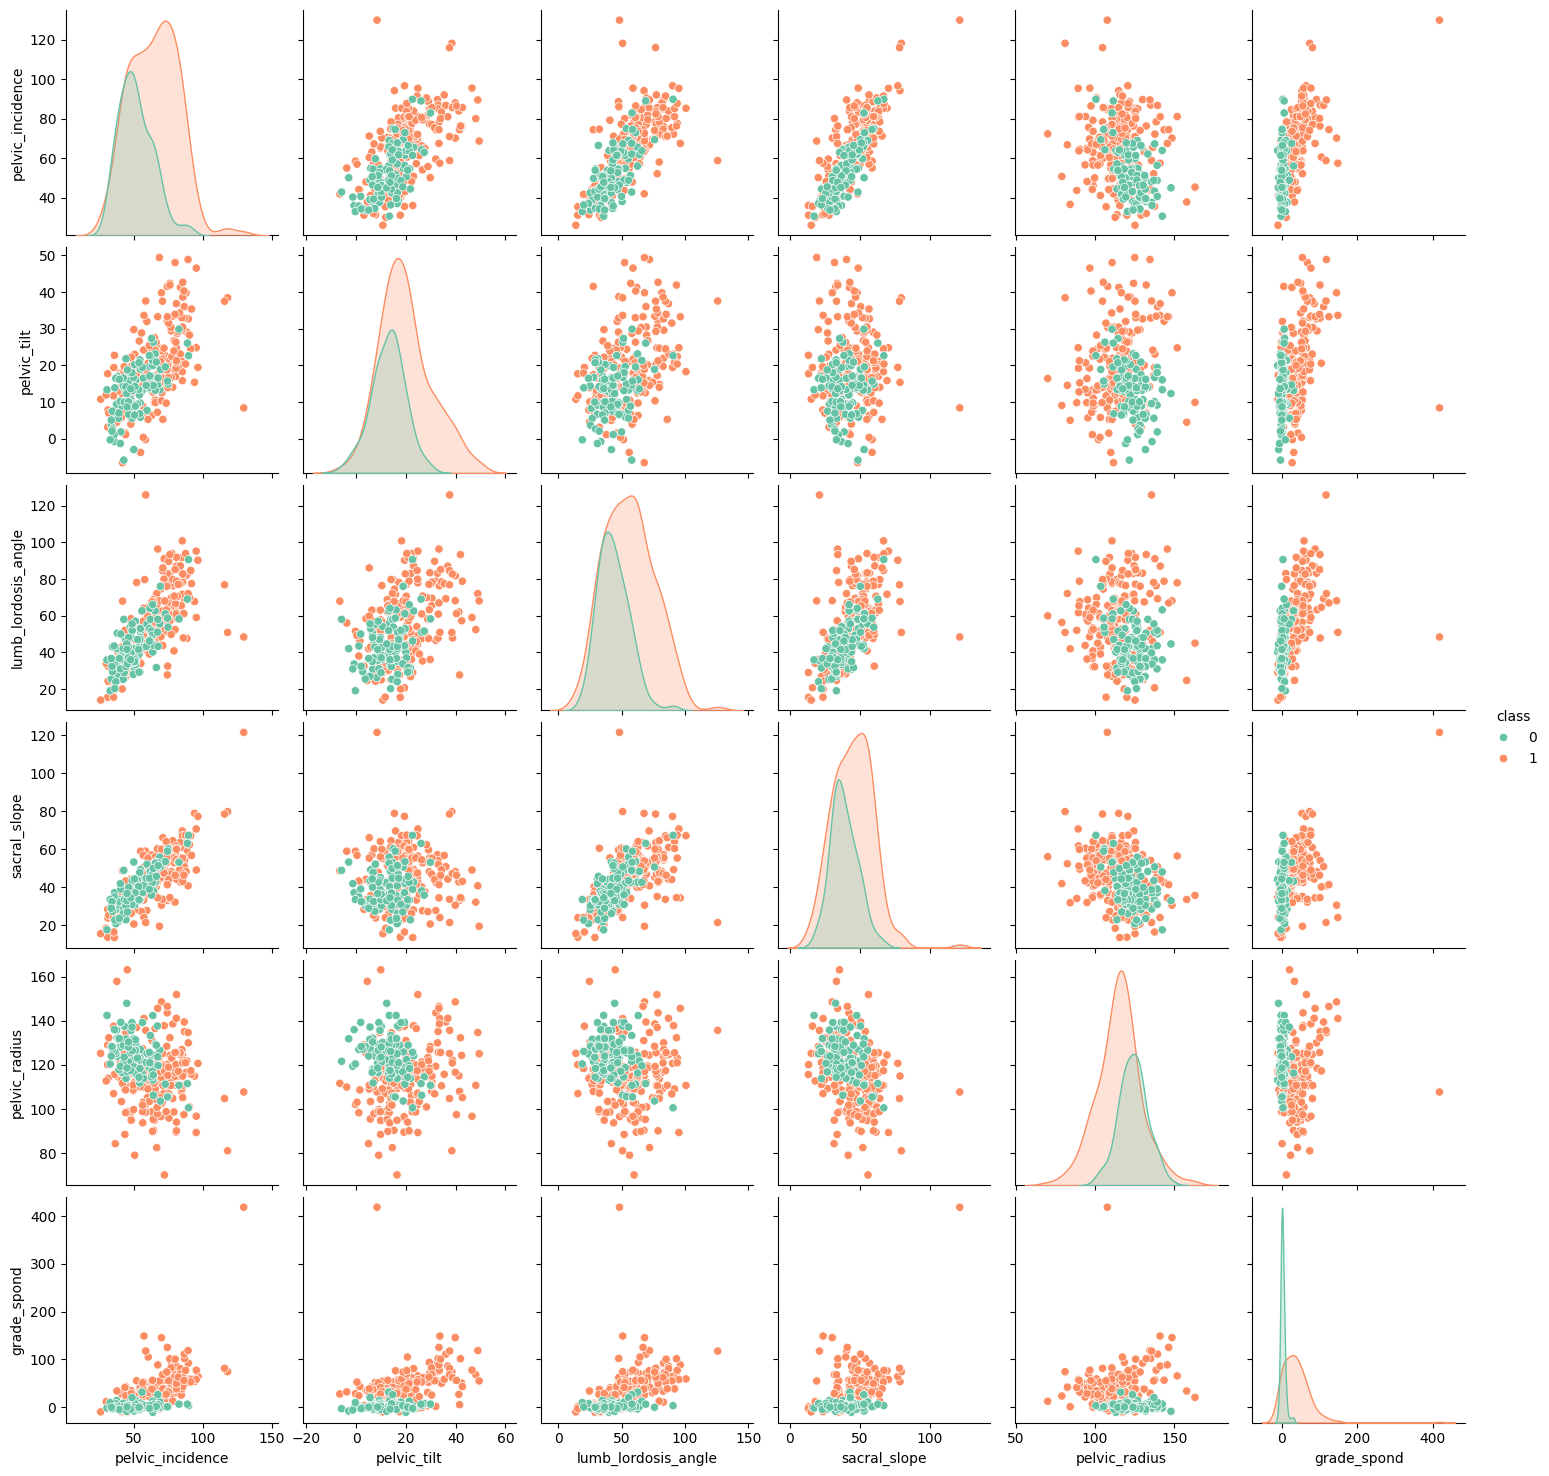

In [264]:
sns.pairplot(bin_df, hue='class', palette='Set2')

#### ii. Boxplots

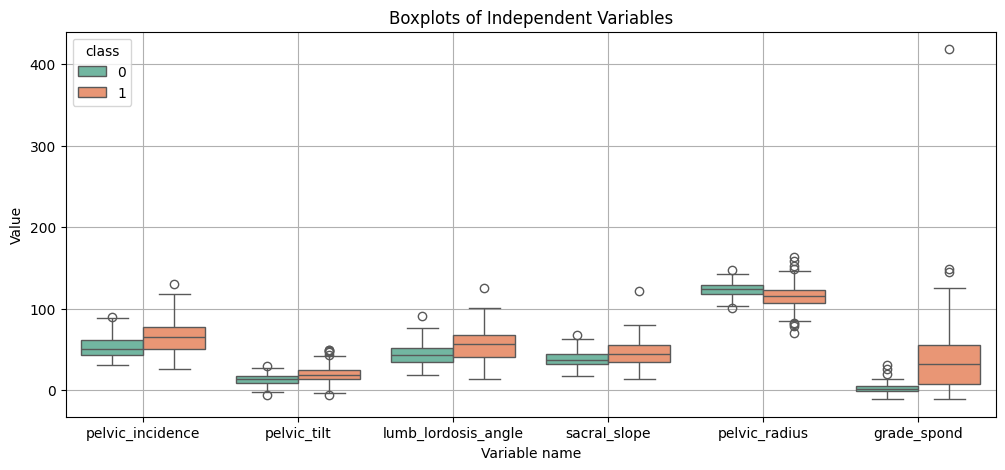

In [265]:
long_df = bin_df.melt(id_vars='class', var_name='Variable name', value_name='Value')

plt.figure(figsize=(12, 5))
sns.boxplot(data=long_df, x='Variable name', y='Value', hue='class', palette='Set2')
plt.title('Boxplots of Independent Variables')
plt.grid(True)
plt.show()

#### iii. Split Data Set

In [266]:
class_0 = bin_df[bin_df['class'] == 0]
class_1 = bin_df[bin_df['class'] == 1]

train_0 = class_0.iloc[:70]
train_1 = class_1.iloc[:140]
train_df = pd.concat([train_0, train_1])
y_train = train_df['class']
x_train = train_df.drop(columns=['class'])

test_0 = class_0.iloc[70:]
test_1 = class_1.iloc[140:]
test_df = pd.concat([test_0, test_1])
y_test = test_df['class']
x_test = test_df.drop(columns=['class'])

### (c) Classification

#### i. Euclidean Metric

In [267]:
def euc_KNN(k=5):
    return sci.neighbors.KNeighborsClassifier(n_neighbors=k, weights='uniform', algorithm='auto',
                           leaf_size=30, p=2, metric='euclidean')

def error_rate(y_hat, y):
    return 1 - (y_hat == y).mean()

#### ii. Test Data

In [268]:
k = list(range(1,209, 3))

# sanity check
# print(k)

models = []
train_error_rate = []
test_error_rate = []
for num in k:
    model = euc_KNN(num)
    model.fit(x_train, y_train)
    models.append(model)

    train_y_hat = model.predict(x_train)
    test_y_hat = model.predict(x_test)

    train_error_rate.append(error_rate(train_y_hat, y_train))
    test_error_rate.append(error_rate(test_y_hat, y_test))

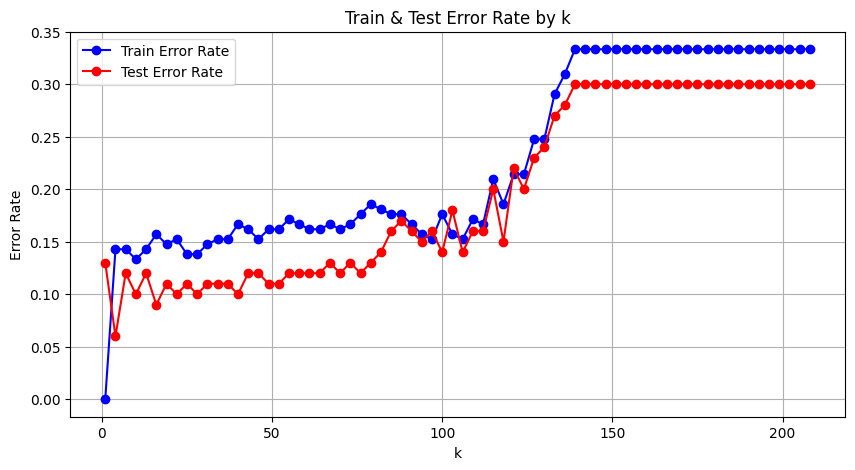

In [269]:
plt.figure(figsize=(10, 5))

plt.plot(k, train_error_rate, label='Train Error Rate', color='blue', marker='o')
plt.plot(k, test_error_rate, label='Test Error Rate', color='red', marker='o')

plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Train & Test Error Rate by k')
plt.legend()
plt.grid(True)
plt.show()

It seems as though that test accuracy peaks somewhere before 30, and therefore I will perform KNN classification on all natrual numbers up to and including 30

In [270]:
k = list(range(1,30))

# sanity check
# print(k)

models = []
train_error_rate = []
test_error_rate = []
for num in k:
    model = euc_KNN(num)
    model.fit(x_train, y_train)
    models.append(model)

    train_y_hat = model.predict(x_train)
    test_y_hat = model.predict(x_test)

    train_error_rate.append(error_rate(train_y_hat, y_train))
    test_error_rate.append(error_rate(test_y_hat, y_test))

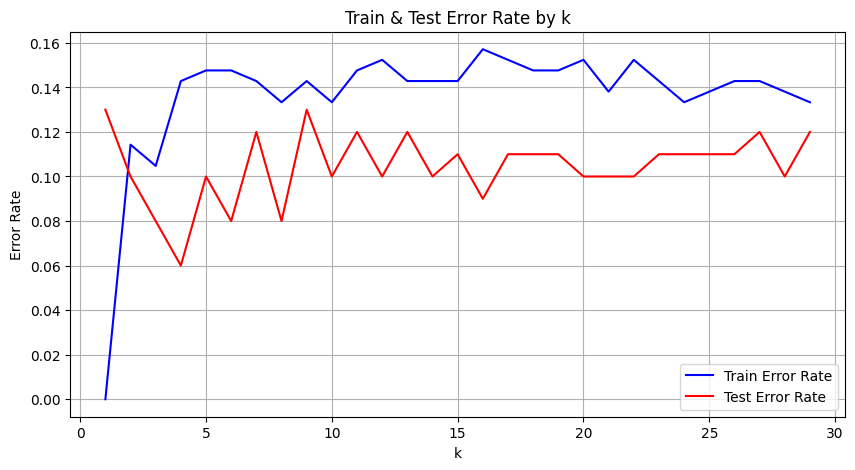

In [271]:
plt.figure(figsize=(10, 5))

plt.plot(k, train_error_rate, label='Train Error Rate', color='blue')
plt.plot(k, test_error_rate, label='Test Error Rate', color='red')

plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Train & Test Error Rate by k')
plt.legend()
plt.grid(True)
plt.show()

As k is shown to have a highest testing accuracy at k = 4, k* =4 

In [272]:
optimal_model = models[3]
y_hat_4 = optimal_model.predict(x_test)
confusion_matrix = sci.metrics.confusion_matrix(y_test, y_hat_4)
t_neg, f_pos, f_neg, t_pos = confusion_matrix.ravel()
print('Confusion Matrix:', confusion_matrix, 
      '\nTrue Positive Rate:', (t_pos / (t_pos + f_neg)), 
      '\nTrue Negative Rate:', (t_neg / (t_neg + f_pos)), 
      '\nPrecision:', sci.metrics.precision_score(y_test, y_hat_4),
      '\nF1 Score:', sci.metrics.f1_score(y_test, y_hat_4)
      )

Confusion Matrix: [[25  5]
 [ 1 69]] 
True Positive Rate: 0.9857142857142858 
True Negative Rate: 0.8333333333333334 
Precision: 0.9324324324324325 
F1 Score: 0.9583333333333334


#### iii. Learning Curve

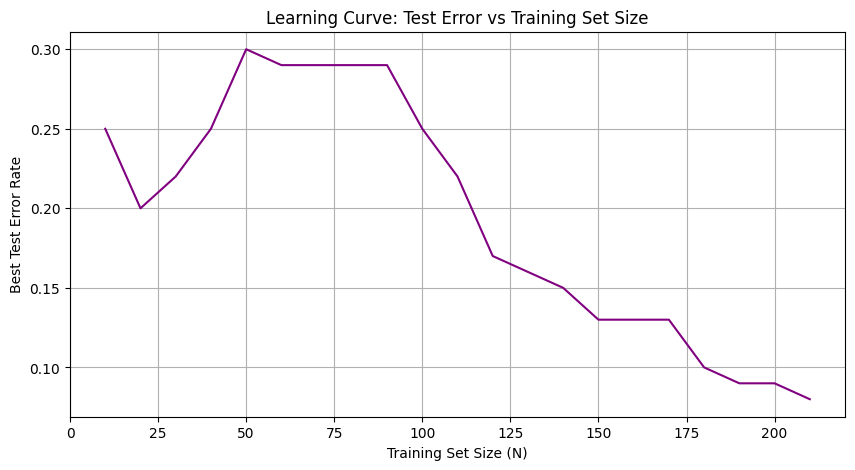

In [273]:
N_values = list(range(10, 211, 10))
best_test_errors = []

class_0 = train_df[train_df['class'] == 0]
class_1 = train_df[train_df['class'] == 1]

for N in N_values:
    n0 = N // 3
    n1 = N - n0

    train_0 = class_0.iloc[:n0]
    train_1 = class_1.iloc[:n1]
    train_df = pd.concat([train_0, train_1])

    x_train = train_df.drop(columns=['class'])
    y_train = train_df['class']

    k_values = list(range(1, N - 3, 5))
    test_errors = []

    for k in k_values:
        model = sci.neighbors.KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        test_errors.append(error_rate(y_test, y_pred))

    best_error = min(test_errors)
    best_test_errors.append(best_error)

plt.figure(figsize=(10, 5))
plt.plot(N_values, best_test_errors, color='purple')
plt.xlabel('Training Set Size (N)')
plt.ylabel('Best Test Error Rate')
plt.title('Learning Curve: Test Error vs Training Set Size')
plt.grid(True)
plt.show()

### (d) Other Metrics

#### i. Minkowski Distance.

##### A. Manhattan Distance with p = 1.

In [274]:
k = list(range(1,197,5))

def minkowski_KNN(k, power):
    return sci.neighbors.KNeighborsClassifier(n_neighbors=k, weights='uniform', algorithm='auto',
                           leaf_size=30, p=power)

In [275]:
class_0 = bin_df[bin_df['class'] == 0]
class_1 = bin_df[bin_df['class'] == 1]

train_0 = class_0.iloc[:70]
train_1 = class_1.iloc[:140]
train_df = pd.concat([train_0, train_1])
y_train = train_df['class']
x_train = train_df.drop(columns=['class'])

test_0 = class_0.iloc[70:]
test_1 = class_1.iloc[140:]
test_df = pd.concat([test_0, test_1])
y_test = test_df['class']
x_test = test_df.drop(columns=['class'])

In [276]:
models = []
train_error_rate = []
test_error_rate = []
for num in k:
    manhattan_model = minkowski_KNN(num, 1)
    manhattan_model.fit(x_train, y_train)
    models.append(manhattan_model)

    train_y_hat = manhattan_model.predict(x_train)
    test_y_hat = manhattan_model.predict(x_test)

    train_error_rate.append(error_rate(train_y_hat, y_train))
    test_error_rate.append(error_rate(test_y_hat, y_test))

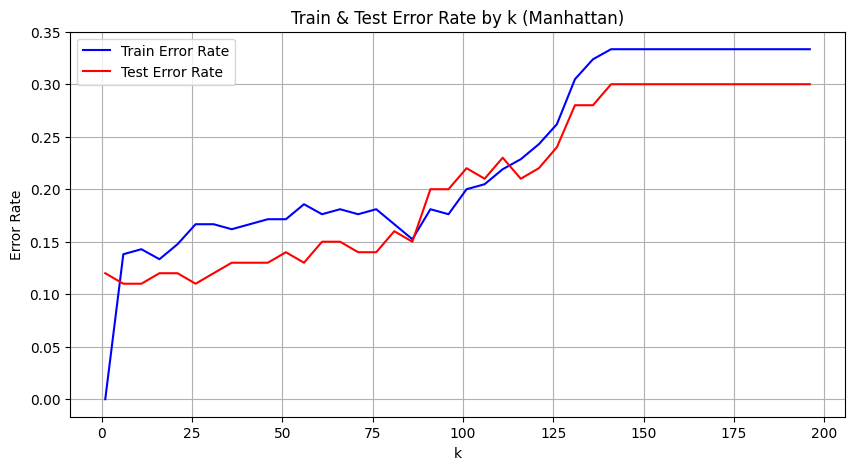

In [277]:
plt.figure(figsize=(10, 5))

plt.plot(k, train_error_rate, label='Train Error Rate', color='blue')
plt.plot(k, test_error_rate, label='Test Error Rate', color='red')

plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Train & Test Error Rate by k (Manhattan)')
plt.legend()
plt.grid(True)
plt.show()

In [278]:
best_error_rate = test_error_rate.index(min(test_error_rate))
k_star = k[best_error_rate]
print('k* =',k_star)
print('best error rate =', test_error_rate[best_error_rate])

k* = 6
best error rate = 0.10999999999999999


##### B. With log10(p) in {0.1, 0.2, 0.3, ... ,1}.

In [279]:
set_values = list(range(1, 11))
for i, num in enumerate(set_values):
    set_values[i] = set_values[i] / 10

# sanity check
# print(set_values)

power = []

for val in set_values:
    power.append(10 ** val)

# sanity check
# print(power)

models = []
train_error_rate = []
test_error_rate = []

for p in power:
    minkowski_model = minkowski_KNN(6, p)
    minkowski_model.fit(x_train, y_train)
    models.append(minkowski_model)

    train_y_hat = minkowski_model.predict(x_train)
    test_y_hat = minkowski_model.predict(x_test)

    train_error_rate.append(error_rate(train_y_hat, y_train))
    test_error_rate.append(error_rate(test_y_hat, y_test))

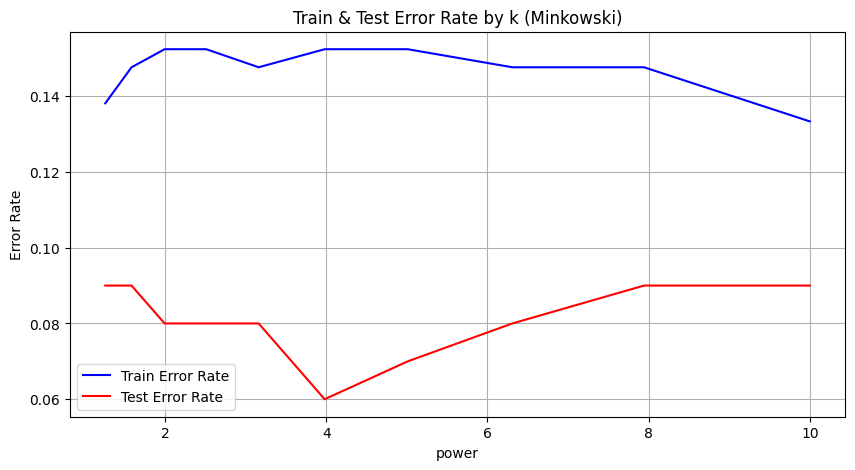

In [280]:
plt.figure(figsize=(10, 5))

plt.plot(power, train_error_rate, label='Train Error Rate', color='blue')
plt.plot(power, test_error_rate, label='Test Error Rate', color='red')

plt.xlabel('power')
plt.ylabel('Error Rate')
plt.title('Train & Test Error Rate by k (Minkowski)')
plt.legend()
plt.grid(True)
plt.show()

In [281]:
best_error_rate = test_error_rate.index(min(test_error_rate))
p_star = set_values[best_error_rate]
print('Best log10(p) =', p_star)
print('best error rate =', test_error_rate[best_error_rate])

Best log10(p) = 0.6
best error rate = 0.06000000000000005


The **best log10(p)** is 0.6

##### C. Chebyshev Distance With p -> infinity.

In [282]:
models = []
train_error_rate = []
test_error_rate = []

for k_values in k:
    chebyshev_model = minkowski_KNN(k_values, float('inf'))
    chebyshev_model.fit(x_train, y_train)
    models.append(chebyshev_model)

    train_y_hat = chebyshev_model.predict(x_train)
    test_y_hat = chebyshev_model.predict(x_test)

    train_error_rate.append(error_rate(train_y_hat, y_train))
    test_error_rate.append(error_rate(test_y_hat, y_test))

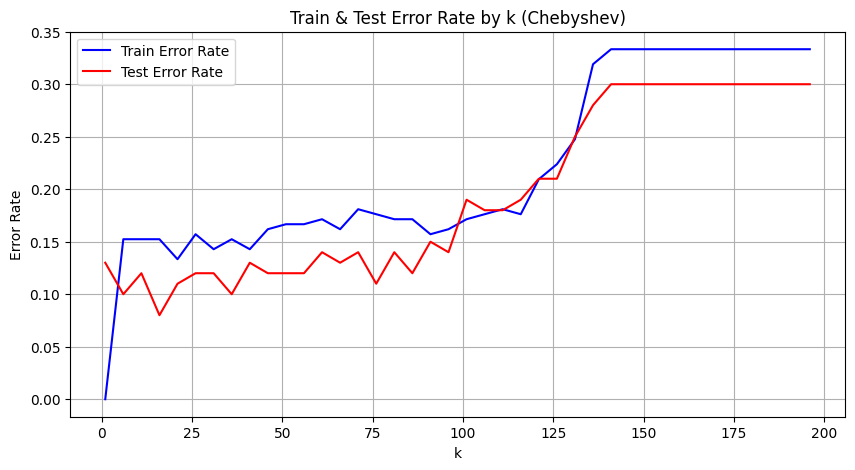

In [283]:
plt.figure(figsize=(10, 5))

plt.plot(k, train_error_rate, label='Train Error Rate', color='blue')
plt.plot(k, test_error_rate, label='Test Error Rate', color='red')

plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Train & Test Error Rate by k (Chebyshev)')
plt.legend()
plt.grid(True)
plt.show()

In [284]:
best_error_rate = test_error_rate.index(min(test_error_rate))
k_star = k[best_error_rate]
print('k* =',k_star)
print('best error_rate =', test_error_rate[best_error_rate])

k* = 16
best error_rate = 0.07999999999999996


#### ii. Mahalanobis Distance.

In [285]:
V = np.cov(x_train.T)
VI = np.linalg.pinv(V)

# done as the footnote 6 indicates, used both inverse and pseudo-inverse to no avail, 
# both output the concerning best k = 1 and 6.

# this is because k should be restrained to smaller values, to get more accurate results
# used the stackoverflow Mahalanobis link to help set up the metric for sklearn

metric_params = {'VI': VI}

models = []
train_error_rate = []
test_error_rate = []

for k_val in k:
    model = sci.neighbors.KNeighborsClassifier(n_neighbors=k_val, metric='mahalanobis', metric_params=metric_params)
    model.fit(x_train, y_train)
    models.append(model)

    train_pred = model.predict(x_train)
    test_pred = model.predict(x_test)

    train_error_rate.append(error_rate(y_train, train_pred))
    test_error_rate.append(error_rate(y_test, test_pred))

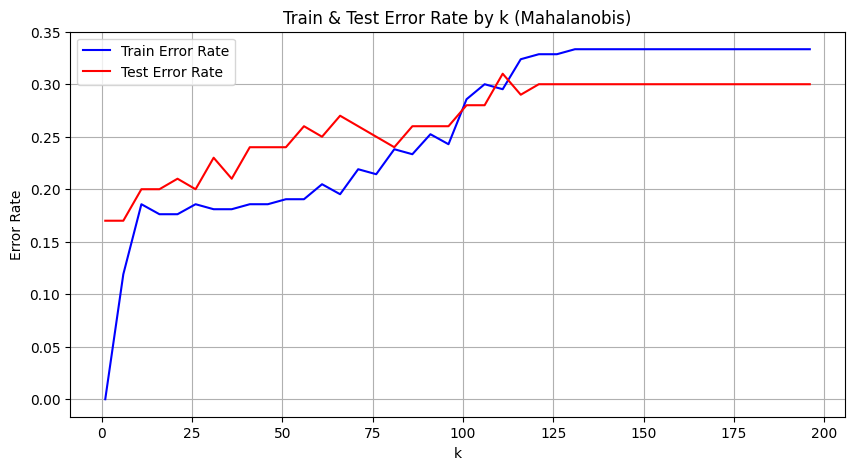

In [286]:
plt.figure(figsize=(10, 5))

plt.plot(k, train_error_rate, label='Train Error Rate', color='blue')
plt.plot(k, test_error_rate, label='Test Error Rate', color='red')

plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Train & Test Error Rate by k (Mahalanobis)')
plt.legend()
plt.grid(True)
plt.show()

In [287]:
best_error_rate = test_error_rate.index(min(test_error_rate))
k_star = k[best_error_rate]
print('k* = ',k_star, ", ", 6, sep='')
print('best error rate =', test_error_rate[best_error_rate])

k* = 1, 6
best error rate = 0.17000000000000004


### (e) Weighted Decision

In [288]:
def KNN_weighted_model(k, distance_metric, power):
    return sci.neighbors.KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='auto', metric=distance_metric, p= power)

#### Euclidean

In [289]:
models = []
train_error_rate = []
test_error_rate = []

for k_values in k:
    euclidian_model = KNN_weighted_model(k_values, 'euclidean', 2)
    euclidian_model.fit(x_train, y_train)
    models.append(euclidian_model)

    train_pred = euclidian_model.predict(x_train)
    test_pred = euclidian_model.predict(x_test)

    train_error_rate.append(error_rate(y_train, train_pred))
    test_error_rate.append(error_rate(y_test, test_pred))

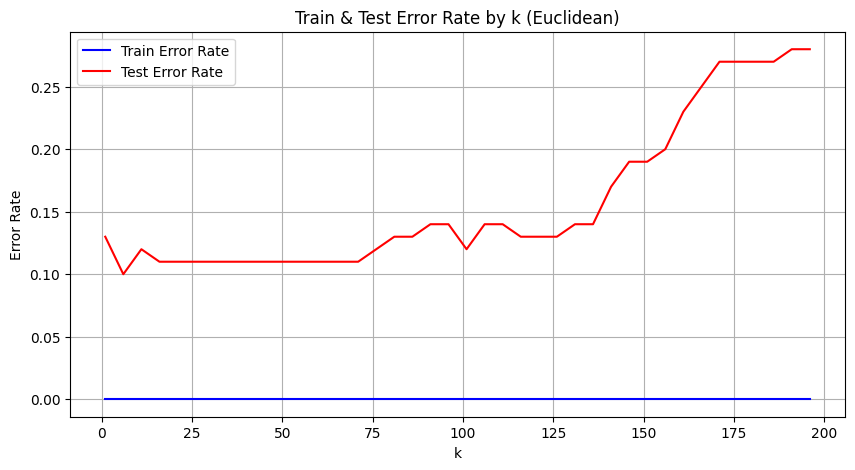

In [290]:
plt.figure(figsize=(10, 5))

plt.plot(k, train_error_rate, label='Train Error Rate', color='blue')
plt.plot(k, test_error_rate, label='Test Error Rate', color='red')

plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Train & Test Error Rate by k (Euclidean)')
plt.legend()
plt.grid(True)
plt.show()

In [291]:
best_error_rate = test_error_rate.index(min(test_error_rate))
k_star = k[best_error_rate]
print('k* =',k_star)
print('best error_rate =', test_error_rate[best_error_rate])

k* = 6
best error_rate = 0.09999999999999998


#### Manhattan

In [292]:
models = []
train_error_rate = []
test_error_rate = []

for k_values in k:
    manhattan_model = KNN_weighted_model(k_values, 'minkowski', 1)
    manhattan_model.fit(x_train, y_train)
    models.append(manhattan_model)

    train_pred = manhattan_model.predict(x_train)
    test_pred = manhattan_model.predict(x_test)

    train_error_rate.append(error_rate(y_train, train_pred))
    test_error_rate.append(error_rate(y_test, test_pred))

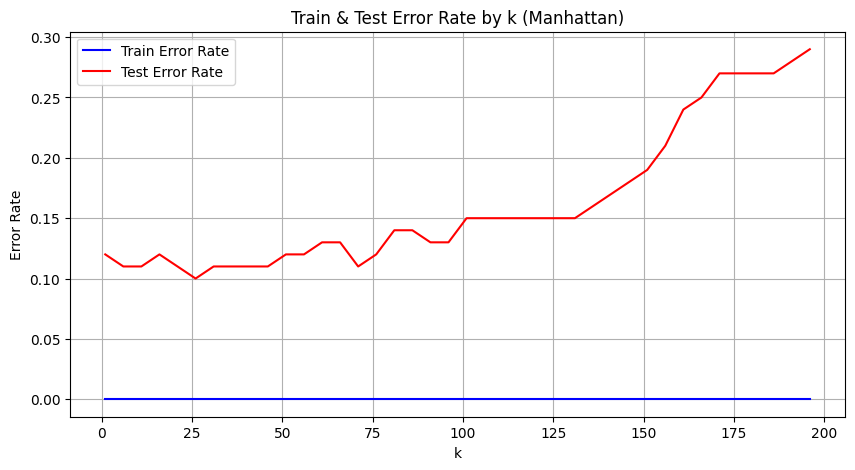

In [293]:
plt.figure(figsize=(10, 5))

plt.plot(k, train_error_rate, label='Train Error Rate', color='blue')
plt.plot(k, test_error_rate, label='Test Error Rate', color='red')

plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Train & Test Error Rate by k (Manhattan)')
plt.legend()
plt.grid(True)
plt.show()

In [294]:
best_error_rate = test_error_rate.index(min(test_error_rate))
k_star = k[best_error_rate]
print('k* =',k_star)
print('best error_rate =', test_error_rate[best_error_rate])

k* = 26
best error_rate = 0.09999999999999998


#### Chebyshev

In [295]:
models = []
train_error_rate = []
test_error_rate = []

for k_values in k:
    chebyshev_model = KNN_weighted_model(k_values, 'minkowski', float('inf'))
    chebyshev_model.fit(x_train, y_train)
    models.append(chebyshev_model)

    train_pred = chebyshev_model.predict(x_train)
    test_pred = chebyshev_model.predict(x_test)

    train_error_rate.append(error_rate(y_train, train_pred))
    test_error_rate.append(error_rate(y_test, test_pred))

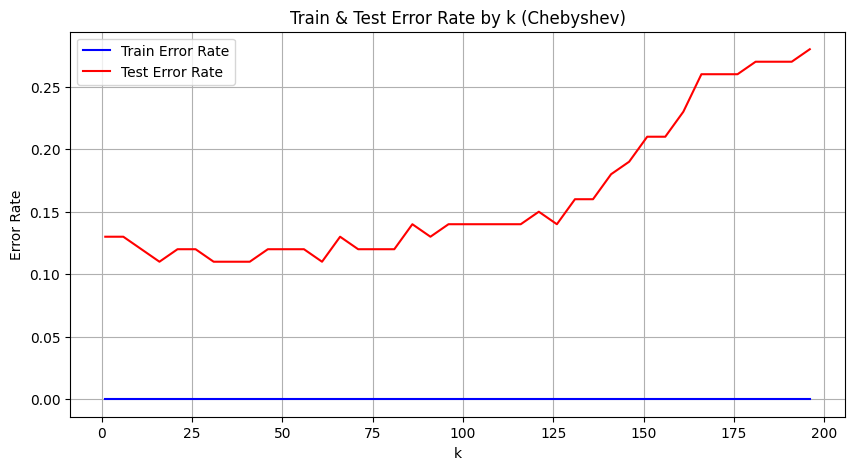

In [296]:
plt.figure(figsize=(10, 5))

plt.plot(k, train_error_rate, label='Train Error Rate', color='blue')
plt.plot(k, test_error_rate, label='Test Error Rate', color='red')

plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Train & Test Error Rate by k (Chebyshev)')
plt.legend()
plt.grid(True)
plt.show()

In [297]:
best_error_rate = test_error_rate.index(min(test_error_rate))
k_star = k[best_error_rate]
print('k* =',k_star)
print('best error rate =', test_error_rate[best_error_rate])

k* = 16
best error rate = 0.10999999999999999


### (f) Training Error Rate

There are multiple instances of models achieving a training error rate of zero due to two reasons. 

The first of which occurs when k is equal to one, no matter the value of other hyperparameters. The perfect training error rate here is attributable to the fact that KNN when only looking at itself, will always classify itself correctly. This happens exclusively in the training set as the class is directly accessible. 

Secondly, when using weighted decisions, I employed weights='distance' to my KNN classifier which accounts for its own position. As the difference of its position to itself is always zero, the calculation of 1 divided by that difference is infinite, resulting in a 100% accuracy, and therefore a 0% error rate no matter the k or k*.

Outside of these exceptions, my best testing error rate was achieved at about 94% with both the Manhatten model with k=6, p=10^0.6 and the Euclidean with k=4

---

# References

**Markdown Guide**: https://www.markdownguide.org/cheat-sheet/

**KNN Classifier Tutorial**: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

**sklearn.metrics**: https://scikit-learn.org/stable/api/sklearn.metrics.html#module-sklearn.metrics

**numpy.linalg**: https://numpy.org/doc/2.1/reference/routines.linalg.html

**Mahalanobis python help**: https://stackoverflow.com/questions/34643548/how-to-use-mahalanobis-distance-in-sklearn-distancemetrics
